In [7]:
#import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import concat
import pandas_datareader as data
import seaborn as sns
import matplotlib.dates as mdates

from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow

In [8]:
#creating a start date and end date
start = '2010-01-01'
end =  datetime.today().strftime("%Y-%m-%d")
#end = '2019-12-31'

company = 'AAPL'
#creating the dataframe
df= data.DataReader(company, 'yahoo', start, end)

#getting the first 5 rows and the last 5 rows
print(df.head(5))
print(df.tail(5))

df.shape

                High       Low      Open     Close       Volume  Adj Close
Date                                                                      
2010-01-04  7.660714  7.585000  7.622500  7.643214  493729600.0   6.515213
2010-01-05  7.699643  7.616071  7.664286  7.656429  601904800.0   6.526477
2010-01-06  7.686786  7.526786  7.656429  7.534643  552160000.0   6.422664
2010-01-07  7.571429  7.466071  7.562500  7.520714  477131200.0   6.410790
2010-01-08  7.571429  7.466429  7.510714  7.570714  447610800.0   6.453411
                  High         Low        Open       Close       Volume  \
Date                                                                      
2022-12-12  144.500000  141.059998  142.699997  144.490005   70462700.0   
2022-12-13  149.970001  144.240005  149.500000  145.470001   93886200.0   
2022-12-14  146.660004  141.160004  145.350006  143.210007   82291200.0   
2022-12-15  141.800003  136.029999  141.110001  136.500000   98931900.0   
2022-12-16  137.649994  1

(3263, 6)

In [9]:
#dropping the adj close column as it is not needed since it similar to the close column and also the date column
#df = df.reset_index()
df.head()
#df = df.drop(['Date','Adj Close'], axis=1)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,7.660714,7.585000,7.622500,7.643214,493729600.0,6.515213
2010-01-05,7.699643,7.616071,7.664286,7.656429,601904800.0,6.526477
2010-01-06,7.686786,7.526786,7.656429,7.534643,552160000.0,6.422664
2010-01-07,7.571429,7.466071,7.562500,7.520714,477131200.0,6.410790
2010-01-08,7.571429,7.466429,7.510714,7.570714,447610800.0,6.453411


In [10]:
#checking if there are any missing datas
missing_data = df[df.isna().any(axis=1)]
print(missing_data)
df.info()
print(df.shape)

Empty DataFrame
Columns: [High, Low, Open, Close, Volume, Adj Close]
Index: []
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3263 entries, 2010-01-04 to 2022-12-16
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3263 non-null   float64
 1   Low        3263 non-null   float64
 2   Open       3263 non-null   float64
 3   Close      3263 non-null   float64
 4   Volume     3263 non-null   float64
 5   Adj Close  3263 non-null   float64
dtypes: float64(6)
memory usage: 178.4 KB
(3263, 6)


Exploring the stock datasets

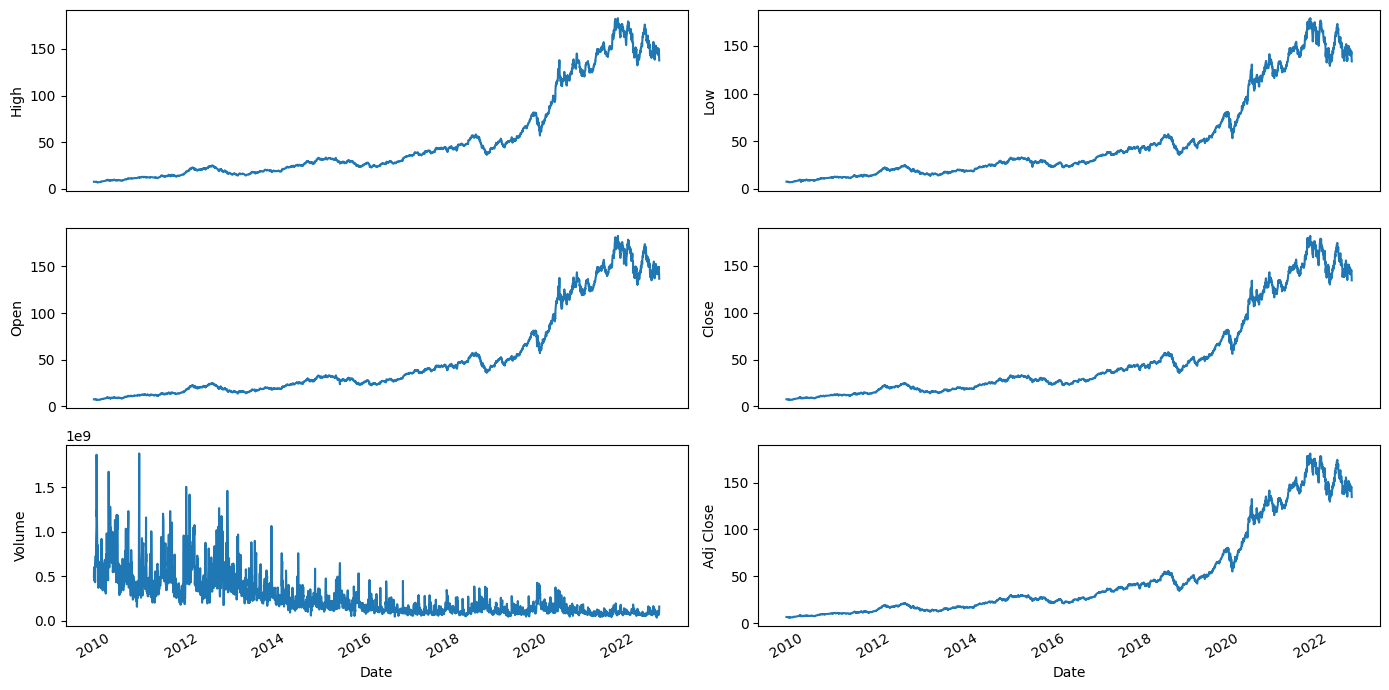

In [11]:
#Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        #ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

High         1.346158
Low          1.345234
Open         1.346111
Close        1.345551
Volume       2.033283
Adj Close    1.348898
dtype: float64
               High       Low      Open     Close    Volume  Adj Close
High       1.000000  0.999843  0.999893  0.999865 -0.496356   0.999817
Low        0.999843  1.000000  0.999864  0.999869 -0.499990   0.999805
Open       0.999893  0.999864  1.000000  0.999713 -0.497773   0.999656
Close      0.999865  0.999869  0.999713  1.000000 -0.498253   0.999942
Volume    -0.496356 -0.499990 -0.497773 -0.498253  1.000000  -0.497289
Adj Close  0.999817  0.999805  0.999656  0.999942 -0.497289   1.000000


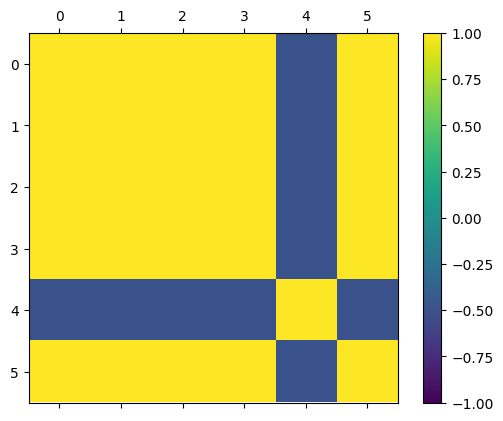

In [12]:
#checking how much skewness
print(df.skew())

#checking the correlations between the data
df_corr = df.corr(method='pearson')
print(df_corr)

#using correlation matrix plot
corr_fig = plt.figure()
axises = corr_fig.add_subplot(111)
axcorr = axises.matshow(df_corr, vmin=-1, vmax=1)

corr_fig.colorbar(axcorr)
ticks = np.arange(0,6,1)

#setting ticks for each axis
axises.set_xticks(ticks)
axises.set_yticks(ticks)

plt.show()

checking for outliers

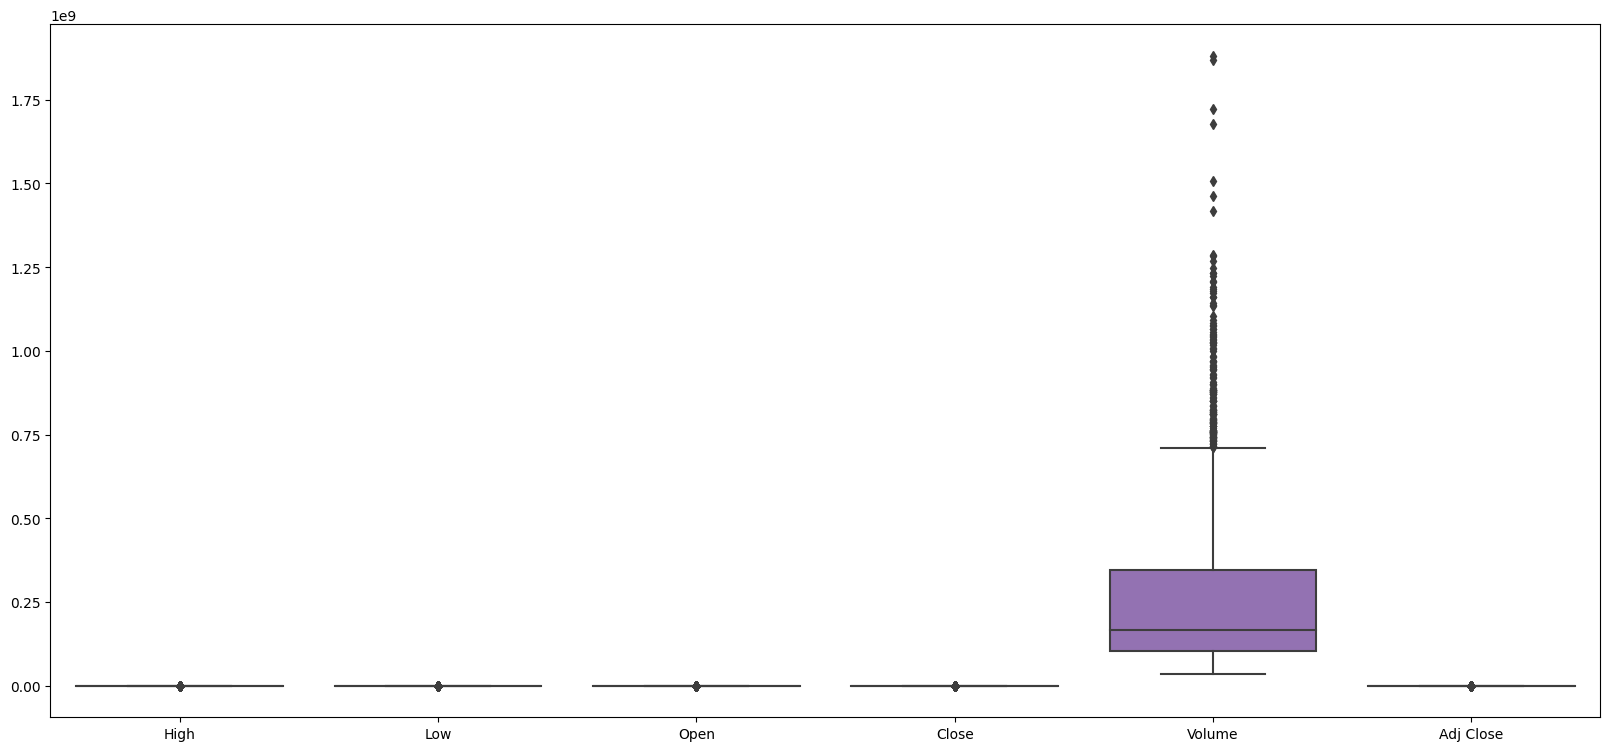

In [15]:
#checking if there is any outliers in the dataset
#use the simple imputer function to replace the empty values in the dataframe

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,9))

# Create a boxplot of the data
sns.boxplot(data=df)
# Show the plot
plt.show()

In [ ]:
#splitting the data into training and testing
train_header = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
target_header = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])
print(df.shape)
print(train_header.shape)
print(target_header.shape)

In [ ]:
#Scaling the stock data so that they fit inbetween 0 and 1
from sklearn.preprocessing import MinMaxScaler
from numpy import set_printoptions
scaler = MinMaxScaler(feature_range=(0,1))
train_header_array = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

train_header_array


In [ ]:
#define how many days in the past we will look into
#the closing price of the particular day would depend on the previous days
historical_data = 50

#########################
# PREPARING TRAINING DATA
#########################
x_train = []
y_train = []

for x in range(historical_data, train_header_array.shape[0]):
    x_train.append(train_header_array[x - historical_data:x, 0])
    y_train.append((train_header_array[x, 0])) #because we are considering only one column

# turning x and y train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)


In [ ]:
# now we are going to reshape the x_train so that it works with the neural network
# the 1 indicates one additional dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
##################
# INSTANTIATE THE MODEL
##################
model = Sequential()

# now we can specify the layers - always add 1 LSTM layer and then a Dropout layer rinse/repeat the final layer is
# the Dense layer that is going to be just one unit, and it's going to the stock price prediction

model.add(LSTM(units=50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units =60, activation = 'relu', return_sequences = True,))
model.add(Dropout(0.3))
model.add(LSTM(units =80, activation = 'relu', return_sequences = True, ))
model.add(Dropout(0.4))
model.add(LSTM(units =120, activation = 'relu'))
model.add(Dropout(0.5))
# prediction of the next closing price
model.add(Dense(units = 1))
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error',metrics = ['mae'])
epochs = 25
history=model.fit(x_train, y_train, epochs=epochs)


# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

SAVE THE MODEL SO IT WOULD BE USEFUL IN STREAMLIT

In [ ]:

model.save('new_lstm_model.h5')

In [ ]:
# LOAD THE DATA - it has to be data the model has not seen before
# this is the time range of the data - we have the data but the model has never seen that data
# so this is a perfect way to see how well it performs
_start = '2010-01-01'
_end = datetime.today().strftime("%Y-%m-%d")
_data = data.DataReader(company,  'yahoo', _start, _end)

In [ ]:
#getting the actual prices
# we need to scale prices, we need to concatenate the full data set that we want to predict on
# this is NOT the predicted price, but the real price from the market
actual_prices = _data['Close'].values

In [ ]:
# this will combine the training data and the test data
total_dataset = pd.concat((df['Close'], _data['Close']), axis=0)


In [ ]:
# this is what our model is going to see as an input, so it can predict
model_inputs = total_dataset[len(total_dataset) - len(_data) - historical_data:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)


MAKE PREDICTIONS ON TEST DATA

In [ ]:
###############################
# MAKE PREDICTIONS ON TEST DATA
###############################

# we don't use the y_test because we already have the stock prices
x_test = []
y_test = []
# if you remove the + 1 it will remove the newest data
for x in range(historical_data, len(model_inputs)):
    x_test.append(model_inputs[x - historical_data:x, 0])
    y_test.append(model_inputs[i, 0])

x_test,y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))



In [ ]:
# now let's predict on the x_test data,the predicted prices are now going to be scaled, so we need to reverse scale them or rather inverse_transform them
y_pred = model.predict(x_test)
# now we are back to the actual predicted price, non-scaled
y_pred = scaler.inverse_transform(y_pred)

# now let plot the predictions instead of just numbers.
plt.plot(actual_prices, color="red", label=f"Actual {company} Price")
plt.plot(y_pred, color="blue", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
# you can also do .pdf for a vector like file (super zoomy)
plt.savefig('Prediction_test.svg')
# this acts as a 'end conn' situation
plt.show()

EVALUATING THE MODEL PERFORMANCES

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#evaluate the model
mae = mean_absolute_error(actual_prices, y_pred)
mse = mean_squared_error(actual_prices, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, y_pred)



#printing the model evaluation values
print('mae:  {:.2f}'.format(mae))
print('mse:  {:.2f}'.format(mse))
print('Root mean square error:  {:.2f}'.format(rmse))
print('R2 score: ', r2)




Making Predictions for Next day

In [ ]:
#########################
# PREDICTING OUR NEXT DAY
#########################

final_data = [model_inputs[len(model_inputs) + 1 - historical_data:len(model_inputs + 1), 0]]
final_data = np.array(final_data)
final_data = np.reshape(final_data, (final_data.shape[0], final_data.shape[1], 1))

print(scaler.inverse_transform(final_data[-1]))

Next_day = model.predict(final_data)
Next_day  = scaler.inverse_transform(Next_day)
print(f' Price Prediction for tomorrow would be: {Next_day}')